# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dill as pickle
from scipy import stats
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 6)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import altair as alt
from altair.expr import datum
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')



from tqdm import tqdm, tqdm_notebook
import quandl

In [3]:
from utils import *

In [4]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key

# tickers, prices = get_quandl_sharadar(free=True)
# prices = prices.assign(Set='free')

tickers, prices = get_sharadar_train()
prices = prices.query('Set == "train"')

C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
print(len(tickers), 'assets in train set.')
prices

9010 assets in train set.


Open    High    Low  Close      Volume  Dividends  \
Ticker Date                                                             
A      1999-11-18  45.50  50.000  40.00  44.00  44739900.0        0.0   
       1999-11-19  42.94  43.000  39.81  40.38  10897100.0        0.0   
       1999-11-22  41.31  44.000  40.06  44.00   4705200.0        0.0   
...                  ...     ...    ...    ...         ...        ...   
ZYNE   2017-08-16   6.20   7.000   6.04   6.36   1673477.0        0.0   
       2017-08-17   6.36   6.639   6.20   6.32    651837.0        0.0   
       2017-08-18   6.26   6.450   6.17   6.25    423696.0        0.0   

                   Closeunadj Lastupdated    Set  
Ticker Date                                       
A      1999-11-18       44.00  2018-02-11  train  
       1999-11-19       40.38  2018-02-11  train  
       1999-11-22       44.00  2018-02-11  train  
...                       ...         ...    ...  
ZYNE   2017-08-16        6.36  2017-11-01  train  
       2017-08-17        6.32  2017-11-01  train  
       2017-08-18        6.25  2017-11-01  train  

[13355739 rows x 9 columns]

In [6]:
ticker_days = prices.groupby('Ticker')[['Set']].count().\
                  rename(columns={'Set': 'n_days'}).reset_index()

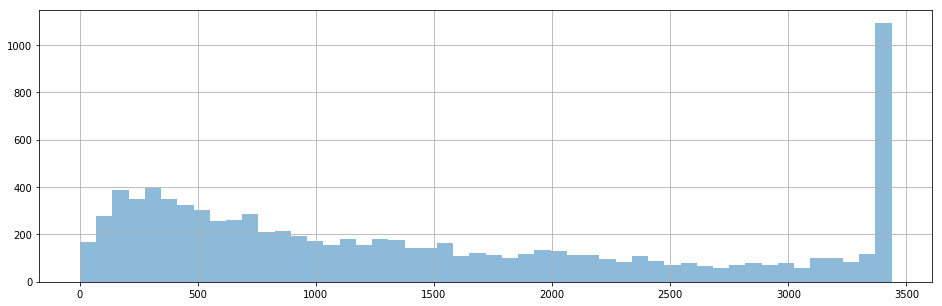

In [7]:
ticker_days.n_days.hist(bins=50, alpha=0.5)

In [9]:
prices.to_csv('input/Sharadar_train.csv')

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

In [ ]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [ ]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [ ]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [ ]:
N_ga = 1500
f_ga = gaussian(N_ga, std=30.)
f_ga = f_ga / f_ga.sum()

In [ ]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Geometric

In [ ]:
f_geo = lambda s: np.exp(filters.convolve1d(np.log(price.Close), f_ga))

### Wiener 

In [ ]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [ ]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

In [ ]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(
    sma=filters.convolve1d(price.Close, f_sma),
    geo=f_geo(price.Close),
    ga=filters.convolve1d(price.Close, f_ga),
    ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
    wi=f_wi(price.Close),
    sp=f_sp(price.Close),
)
results[:1000].plot(alpha=0.5);

In [ ]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [ ]:
def smooth_price(df, N=1500, sd=20.):
    f_ga = gaussian(N_ga, std=sd)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [ ]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [ ]:
results = smooth_price(price)

In [ ]:
results

In [ ]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [ ]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [ ]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [ ]:
peaks

In [ ]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [ ]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [ ]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [ ]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

In [ ]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

In [ ]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0,
                facecolor=pal[0], alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0,
                facecolor=pal[4], alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Smoothed, label='Smoothed')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

In [ ]:
res2 = find_trends(price)
plot_trends(res2)

## Filters and lags

In [ ]:
results = smooth_price(price, sd=30)
results = results.assign(SMA=results.Close.rolling(60).mean())
results = results.assign(SMA_g=results.Close.rolling(120, win_type='gaussian').mean(std=30))
# results = results.assign(SMA=results.SMA.shift(-30))
results[['Close', 'Smoothed', 'SMA', 'SMA_g']].plot()

In [ ]:
res_0 = smooth_price(price, sd=30)
res_lag = price.assign(Smoothed=results.Close.rolling(60).mean())

In [ ]:
trends_0 = find_trends(price, sd=30)
trends_lag = find_trends(res_lag, True)

In [ ]:
confusion_matrix(trends_0.Trend.values, trends_lag.Trend.values) / len(trends_0)

In [ ]:
confusion_matrix(trends_0.Trend.values,
                 trends_lag.Trend.shift(-30).fillna(method='ffill').values) / len(trends_0)

In [ ]:
confusion_matrix(trends_0.Trend.values,
                 trends_0.Trend.shift(30).fillna(method='bfill').values) / len(trends_0)

# Sample...

## A single asset 

In [ ]:
from utils import *

In [ ]:
ticker = np.random.choice(tickers)
# ticker = 'TFCO'
price = prices.loc[ticker]
print(len(price), 'days.')

In [ ]:
trends = find_trends(price, sd=20.)
plot_trends(trends, ticker)

In [ ]:
trends

In [ ]:
trends.groupby('n_Trend').first().ICAGR.plot.hist(bins=20, alpha=0.5)

In [ ]:
trends.groupby('n_Trend').Trend.count()

In [ ]:
summarise_trends(price, sd=20)

In [ ]:
trends2 = find_trends(price, sd=5.)
plot_trends(trends2, ticker)

In [ ]:
summarise_trends(price, sd=5)

In [ ]:
sds = np.arange(5, 250, step=5)
sum_trends = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

In [ ]:
sum_trends

In [ ]:
sum_trends.set_index('sd')[['mean', 'min', '50%', 'max']].plot();

In [ ]:
sum_trends.set_index('sd')[['trend_freq']].plot();

In [ ]:
sum_trends.set_index('sd')[['ICAGR', 'mean_ICAGR', 'neg_ICAGR']].plot();

In [ ]:
sum_trends.set_index('sd')[['Bliss']].plot();

## Multiple assets

### Single thread

In [ ]:
from utils import *
# summarise_trends(prices.loc['A'], sd=100)
# results = pickle.load(open('output/Finding the trends - sd values for filtering.pickle', 'rb'))

In [ ]:
# n_tickers = 1000
sds = np.arange(5, 300, step=5)

results = []
# grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
grouped = prices.groupby('Ticker')
# grouped = prices.loc[list(set(results_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    res_g = []
    for s in tqdm_notebook(sds, desc='sd:', leave=False, postfix=dict(n_days=str(len(group)))):
        try:
            res_g.append(summarise_trends(group.reset_index('Ticker'), s))
        except:
            pass
    try:
        results.append(pd.concat(res_g, axis=0).assign(Ticker=name))
    except:
        pass

In [ ]:
# pickle.dump(results, open('output/Finding the trends - std values for filtering.pickle', 'wb'))

### Results

In [ ]:
results = pickle.load(open('output/Finding the trends - std values for filtering.pickle', 'rb'))

In [ ]:
results_df = pd.concat(results, axis=0, sort=True)
# results_df = results_df.query('n_days > 3 * sd')
results_df = results_df.set_index('Ticker').loc[np.random.choice(results_df.Ticker.values, size=500)]
results_df = results_df.reset_index().query('n_days > 3 * sd')
results_df

####  ICAGR

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='ICAGR',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(ICAGR)'
)
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='ci1(ICAGR)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='max(ICAGR)',
).properties(width=800, height=300).interactive()
total_interval + confidence_interval + line

#### Max Drawdown

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='Max_Drawdown',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Max_Drawdown)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='ci1(Max_Drawdown)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='max(Max_Drawdown)',
)
# total_interval + 
confidence_interval + line

#### Bliss

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y='Bliss',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=300
).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Bliss)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='ci1(Bliss)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='max(Bliss)',
)
# total_interval + 
confidence_interval + line

#### Error frequency

In [ ]:
line = alt.Chart(results_df.reset_index(), title='Number of negative ratios / number of trends').mark_line().encode(
    x='sd',
    y='mean(neg_freq)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='ci1(neg_freq)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='max(neg_freq)',
)
# total_interval + 
confidence_interval + line

In [ ]:
alt.Chart(results_df.assign(Color = results_df.neg_ICAGR > 0).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('Color', title='neg_ICAGR'),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df.assign(neg_ICAGR = results_df.neg_ICAGR.astype(str)).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('neg_ICAGR', title='neg_ICAGR',
                    scale=alt.Scale(domain=[str(i) for i in np.arange(11)])),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

#### Trend frequency and duration

In [ ]:
alt.Chart(results_df).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('trend_freq', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df, title='Trend duration (days)').mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('mean', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

## Lab

### Ideal System (that cheats...)

In [8]:
from trading_strategies import *
from utils import *

In [25]:
# ticker = np.random.choice(results_df.Ticker)  
ticker = np.random.choice(tickers)
# ticker = 'IDWK' # 'OCLR1' # 'NCMV'
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

ASPM 1719 days.


In [26]:
price

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set
Date,,,,,,,,,
2000-02-01,27.000,32.250,26.25,32.00,266200.0,0.0,32.00,2017-11-01,train
2000-02-02,32.000,37.625,30.75,35.75,457200.0,0.0,35.75,2017-11-01,train
2000-02-03,36.625,57.125,35.00,50.75,497500.0,0.0,50.75,2017-11-01,train
...,...,...,...,...,...,...,...,...,...
2006-11-29,18.200,18.580,18.05,18.57,92664.0,0.0,18.57,2017-11-01,train
2006-11-30,18.570,19.050,18.50,18.96,115288.0,0.0,18.96,2017-11-01,train
2006-12-01,18.900,18.940,18.00,18.20,175640.0,0.0,18.20,2017-11-01,train


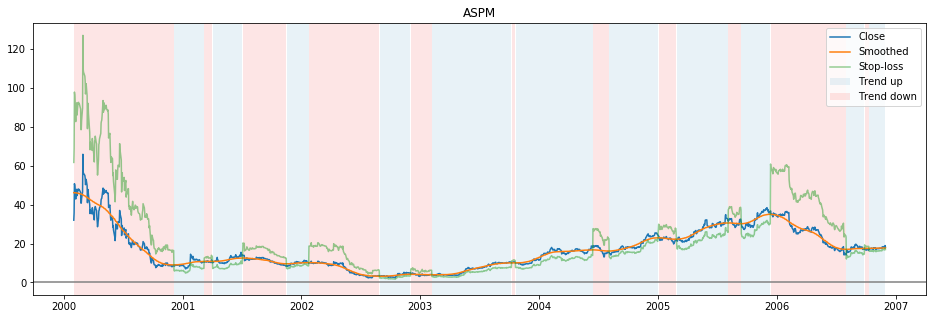

In [27]:
trends = find_trends(price, sd=20)
plot_trends(trends, ticker)

In [28]:
trends.groupby('n_Trend').first().iloc[5:].head(6)

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End
n_Trend,,,,,,,,,,,,,,,,,,,,
6.0,8.55,8.64,8.300,8.54,48500.0,0.0,8.54,2017-11-01,train,9.579824,1.0,0.153646,0.059929,0.152885,0.010667,1.185363,0.910888,5.928490,2001-11-16,2002-01-23
7.0,10.37,10.37,10.000,10.00,5000.0,0.0,10.00,2017-11-01,train,10.233608,-1.0,0.868484,0.083984,0.297414,0.011429,1.674000,0.868831,1.000399,2002-01-24,2002-08-28
8.0,3.40,3.50,3.251,3.30,22600.0,0.0,3.30,2017-11-01,train,3.172242,1.0,0.319209,0.091509,0.261818,0.014706,1.500000,1.554639,4.870284,2002-08-29,2002-12-02
9.0,4.95,4.95,4.440,4.44,73800.0,0.0,4.44,2017-11-01,train,4.215868,-1.0,0.537736,0.107897,0.258065,0.021951,1.076577,0.419947,0.780954,2002-12-03,2003-02-05
10.0,4.15,4.15,4.060,4.06,27000.0,0.0,4.06,2017-11-01,train,3.942446,1.0,0.252066,0.064906,0.295161,0.012438,2.519704,1.379584,5.473105,2003-02-06,2003-10-08
11.0,10.30,10.50,10.000,10.15,27685.0,0.0,10.15,2017-11-01,train,10.030136,-1.0,0.096715,0.038105,0.067171,0.014286,0.990148,-0.327860,-3.389953,2003-10-09,2003-10-20


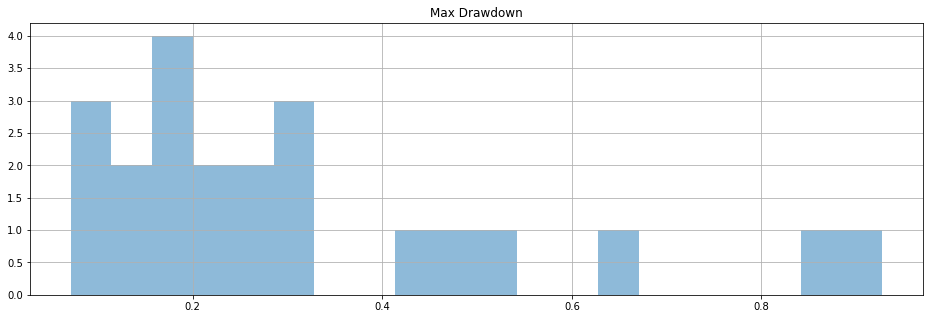

In [29]:
trends.groupby('n_Trend').first().Max_Drawdown.hist(bins=20, alpha=0.5)
plt.title('Max Drawdown')
plt.show()

In [30]:
cheat_ts = Oracle_Trading_Strategy(price, equity=1e6, name=ticker, #heat=0.63,
                                   trend=trends.Trend.values,
                                   max_dd= #trends.max_TR.fillna(method='ffill').values + \
                                           trends.Max_Drawdown.fillna(method='ffill').values,
                                           #np.ones_like(trends.Max_Drawdown) * 0.2,
                                  )
cheat_ts.excecute(warmup=1)

In [31]:
cheat_ts.performance

{'Years': 6.846945778997941,
 'Ratio': 3.3964761045000005,
 'ICAGR': 0.1785815886032814,
 'Max_Drawdown': 0.09009211218762991,
 'Bliss': 1.9822111422069815,
 'Lake_Ratio': 0.022465846631731037,
 'Sea_Ratio': 0.04725889549447664}

In [32]:
trades_profit = cheat_ts.get_trades_profit()
trades_profit.head(3)

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct
0,0,2000-02-07,43.1250,-2198.0,1,2000-02-29,63.81250,-45471.1250,-0.479710
1,2,2000-03-03,55.5000,-1712.0,3,2000-04-25,43.34375,20811.5000,0.219032
2,4,2000-05-08,46.0315,-2117.0,5,2000-06-16,33.00000,27587.6855,0.283100


In [33]:
cheat_ts.get_trades_profit().tail(6)

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct
20,40,2005-08-10,32.0050,-23366.0,41,2005-09-16,29.120,67410.9100,0.090142
21,42,2005-09-22,28.0165,30645.0,43,2005-12-14,36.095,247565.6325,0.288348
22,44,2005-12-15,34.9400,-8935.0,45,2006-08-04,15.785,171149.9250,0.548226
23,46,2006-08-10,15.9900,65027.0,47,2006-09-29,17.355,88761.8550,0.085366
24,48,2006-10-02,16.7000,-100681.0,49,2006-10-13,17.540,-84572.0400,-0.050299
25,50,2006-10-17,17.5700,133257.0,51,2006-12-01,18.100,70626.2100,0.030165


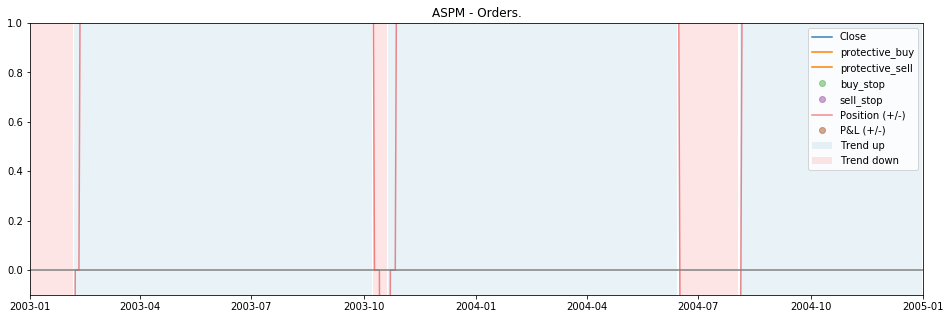

In [34]:
cheat_ts.plot_orders()
plt.xlim((datetime(2003, 1, 1), datetime(2005, 1, 1)));
plt.ylim((-0.1, 1));

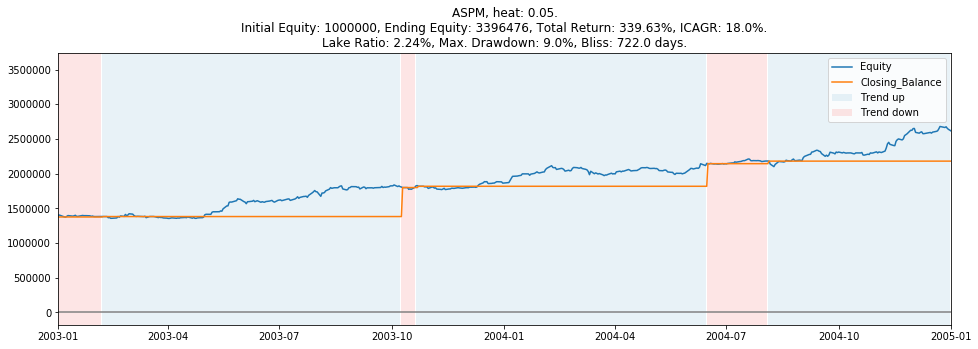

In [35]:
cheat_ts.plot_equity()
plt.xlim((datetime(2003, 1, 1), datetime(2005, 1, 1)));
# plt.ylim((-10, 50));

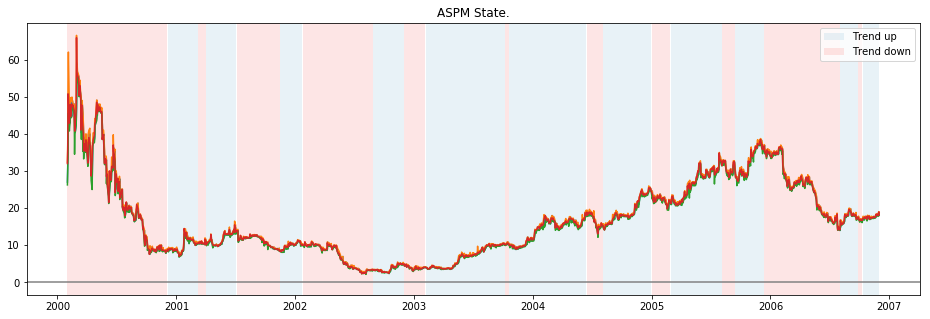

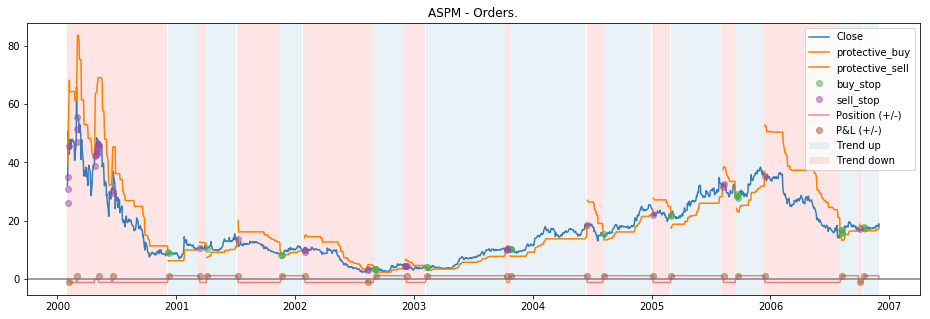

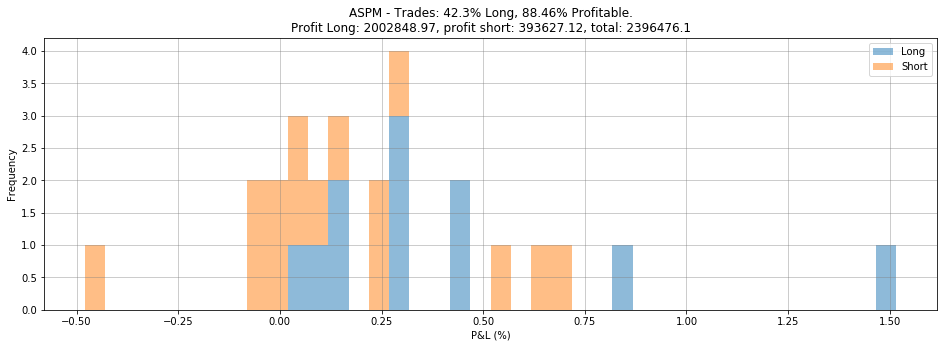

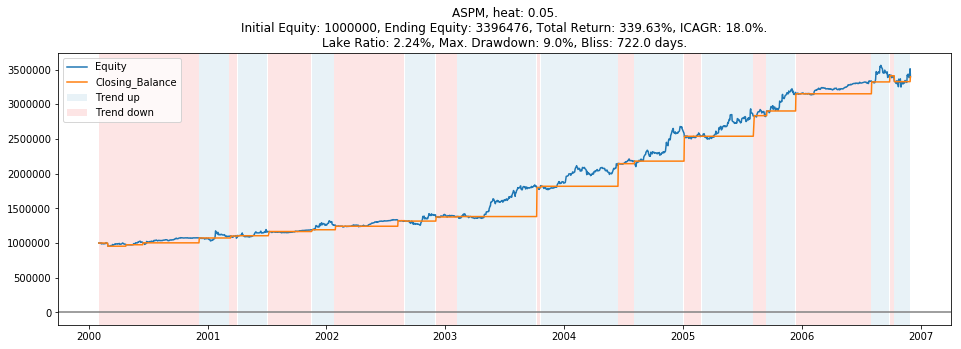

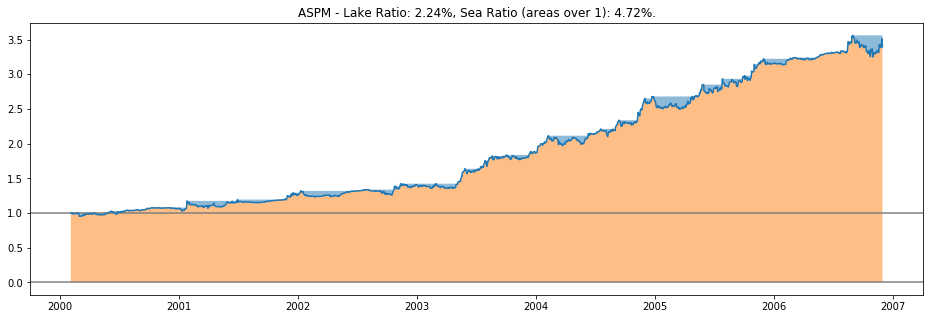

In [36]:
cheat_ts.plot_state()
cheat_ts.plot_orders()
cheat_ts.plot_trades()
cheat_ts.plot_equity()
cheat_ts.plot_lake_ratio()

### Lag vs sd

In [8]:
from trading_strategies import *
from utils import *
from joblib import Parallel, delayed

In [10]:
ticks = np.random.choice(tickers, size=50, replace=False)
lags = np.concatenate((np.arange(0, 20, 5), np.arange(20, 51, 10)))
sds = np.concatenate((np.arange(5, 40, 5), np.arange(40, 81, 5)))
heats = np.concatenate((np.arange(0.025, 0.1, 0.025), np.arange(0.1, 0.9, 0.1)))

print('Tickers:', len(ticks), ', lags: ', len(lags),
      ', sds: ', len(sds), ', heats: ', len(heats),
      '.\nSteps: ', len(ticks) * len(lags) * len(sds) * len(heats), sep='')
print('')
print('ticks:', ticks)
print('lags:', lags)
print('sds:', sds)
print('heats:', heats)

Tickers:50, lags: 8, sds: 16, heats: 12.
Steps: 76800

ticks: ['SGMA' 'VRTS' 'PTSC' 'AAPC' 'AMOV' 'SCCB1' 'SFUN1' 'PNVN' 'SENGQ' 'ASWX'
 'WPM' 'NR' 'NPTH' 'EFD1' 'DWCH' 'CBAI' 'BODY' 'SNBT' 'JONE' 'STRS' 'SHOP'
 'DCIX' 'RMI' 'BKE' 'WGHI' 'NAVG' 'ALR' 'MPO1' 'APHB' 'QADA' 'MGI' 'AYS'
 'BRKC1' 'AWAY' 'CBB' 'L1' 'STCL' 'NVDA' 'SRSC' 'CCO' 'HCCH' 'UCTT' 'JSTN'
 'VRTB' 'PS' 'NLC1' 'LGCY' 'TPRE' 'MCDT' 'HTN']
lags: [ 0  5 10 15 20 30 40 50]
sds: [ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80]
heats: [0.025 0.05  0.075 0.1   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8  ]


In [11]:
pr_ticks = prices.loc[ticks]
pr_ticks

Open   High    Low  Close     Volume  Dividends  \
Ticker Date                                                           
AAPC   2015-04-29  10.01  10.08  10.01  10.06   665400.0        0.0   
       2015-04-30  10.03  10.19  10.03  10.17   122244.0        0.0   
       2015-05-01  10.10  10.19  10.10  10.19     6098.0        0.0   
...                  ...    ...    ...    ...        ...        ...   
WPM    2014-03-20  24.76  25.40  24.53  25.14  4408123.0        0.0   
       2014-03-21  25.30  25.55  24.80  25.04  6416934.0        0.0   
       2014-03-24  24.72  24.81  23.20  23.27  6932030.0        0.0   

                   Closeunadj Lastupdated    Set  
Ticker Date                                       
AAPC   2015-04-29       10.06  2017-11-01  train  
       2015-04-30       10.17  2017-11-01  train  
       2015-05-01       10.19  2017-11-01  train  
...                       ...         ...    ...  
WPM    2014-03-20       25.14  2017-11-01  train  
       2014-03-21       25.04  2017-11-01  train  
       2014-03-24       23.27  2017-11-01  train  

[69499 rows x 9 columns]

In [12]:
def get_oracles(ticker, sd=30, lag=0, heat=0.05):
    
    price = pr_ticks.loc[ticker]
    tr = find_trends(price, sd).shift(lag)
    trend = tr.Trend.fillna(value=0)
    max_dd = (#tr.ATR.fillna(method='ffill').fillna(method='bfill').values + 
              tr.Max_Drawdown.fillna(method='ffill').fillna(method='bfill').values)
    
    ch_ts = Oracle_Trading_Strategy(price, equity=1e6, name=ticker, 
                                    heat=heat,
                                    trend=trend,
                                    max_dd=max_dd)
    ch_ts.excecute(warmup=1)
    f = 'output/Oracles/' + ticker + '_' + str(sd) + '_' + str(lag) + '_' + str(heat) + '.pickle'
    pickle.dump(ch_ts, file=open(f, 'wb'))
    
    return {'Ticker': ticker, 'sd': sd, 'lag':lag, 'heat': heat, 'n_days': len(price),
            **ch_ts.performance, 'File_Results': f}

In [ ]:
res_perf = []

for t in tqdm_notebook(ticks):
    perf = Parallel(-1, verbose=1)(
        delayed(get_oracles)(t, s, l, h)
        for s, l, h in itertools.product(sds, lags, heats))
    res_perf.append(perf)

In [44]:
def read_oracle(f):
    ticker, sd, lag, heat = f.replace('.pickle', '').split('_')
    sd = float(sd)
    lag = int(lag)
    heat = float(heat)
    ch_ts = pickle.load(file=open(oracle_dir + f, 'rb'))
    price = ch_ts.prices_df
    return {'Ticker': ticker, 'sd': sd, 'lag':lag, 'heat': heat, 'n_days': len(price),
            **ch_ts.performance, 'File_Results': f}

oracle_dir = 'output/Oracles/'

res_perf = [read_oracle(f) for f in os.listdir('output/Oracles/')]

In [46]:
pickle.dump(res_perf, open('output/Finding the trends - oracles.pickle', 'wb'))

In [54]:
perf_df = pd.concat([DataFrame(Series(p)).transpose() for p in res_perf], axis=0)
# perf_df = perf_df.assign(
#     ICAGR = perf_df.ICAGR.clip_lower(-20),
#     Bliss = perf_df.Bliss.clip_lower(-20),
# )
perf_df.to_excel('output/Finding the trends - perf_df.xlsx')
perf_df

,Ticker,sd,lag,heat,n_days,Years,Ratio,ICAGR,Max_Drawdown,Bliss,Lake_Ratio,Sea_Ratio,File_Results
0,AAPC,10,0,0.025,334,1.6884,1.00384,0.00226922,0.0304106,0.0746194,0.0146885,-6.70304,AAPC_10_0_0.025.pickle
0,AAPC,10,0,0.05,334,1.6884,1.00735,0.00433648,0.0595925,0.0727689,0.0294381,-6.65006,AAPC_10_0_0.05.pickle
0,AAPC,10,0,0.075,334,1.6884,1.01053,0.00620357,0.0876135,0.0708061,0.0442502,-6.59747,AAPC_10_0_0.07500000000000001.pickle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,WPM,80,5,0.6,2348,13.768,714.76,0.477334,0.963056,0.495645,0.633513,0.6367,WPM_80_5_0.6.pickle
0,WPM,80,5,0.7,2348,13.768,592.622,0.463724,0.985721,0.470441,1.22432,1.23105,WPM_80_5_0.7000000000000001.pickle
0,WPM,80,5,0.8,2348,13.768,310.253,0.416719,0.996301,0.418266,2.94856,2.96974,WPM_80_5_0.8.pickle


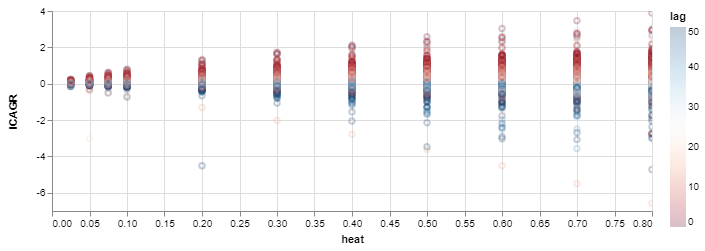

In [55]:
alt.Chart(perf_df.query('sd == 25')).mark_point(opacity=0.25).encode(
    x='heat',
    y='ICAGR',
    color=alt.Color('lag', scale=alt.Scale(scheme='redblue')),
    tooltip=['Ticker', 'sd', 'lag', 'ICAGR', 'Max_Drawdown', 'Bliss', 'Years', 'Lake_Ratio'],
).properties(width=600, height=200).interactive()

Heat: 0.05


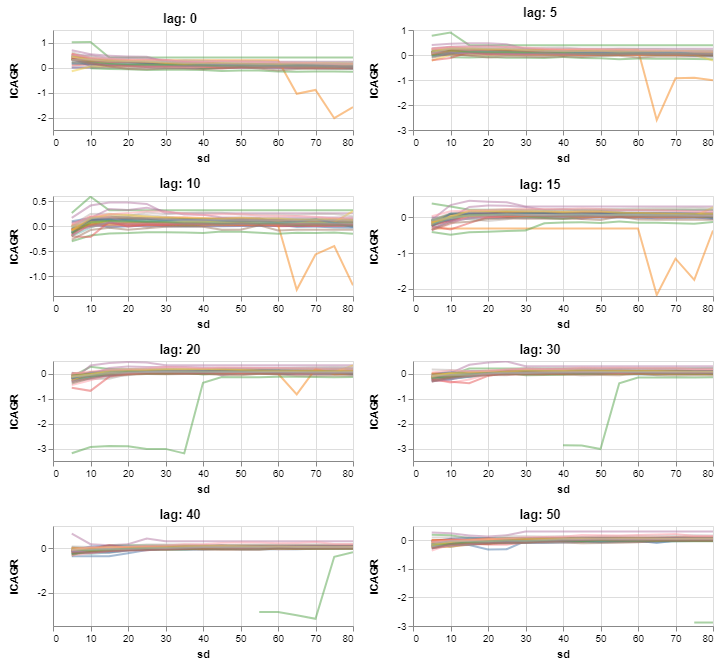

In [56]:
heat = 0.05
print('Heat: ' + str(heat))
base = alt.Chart().mark_line(
    opacity=0.5,
    point=False,
).encode(
    x='sd',
    y='ICAGR',
    color=alt.Color('Ticker', legend=None),
    tooltip=['Ticker', 'sd', 'lag', 'ICAGR', 'Max_Drawdown', 'Bliss', 'heat', 'Lake_Ratio', 'Years'],
).properties(width=300, height=100).interactive()


chart = alt.vconcat(data=perf_df)
for i in range(len(lags) // 2):
    row = base.properties(title='lag: ' + str(lags[2 * i])).\
        transform_filter(datum.lag==lags[2 * i]).transform_filter(datum.heat==heat)
    row |= base.properties(title='lag: ' + str(lags[2 * i + 1])).\
        transform_filter(datum.lag==lags[2 * i + 1]).transform_filter(datum.heat==heat)
    chart &= row
chart

sd: 25


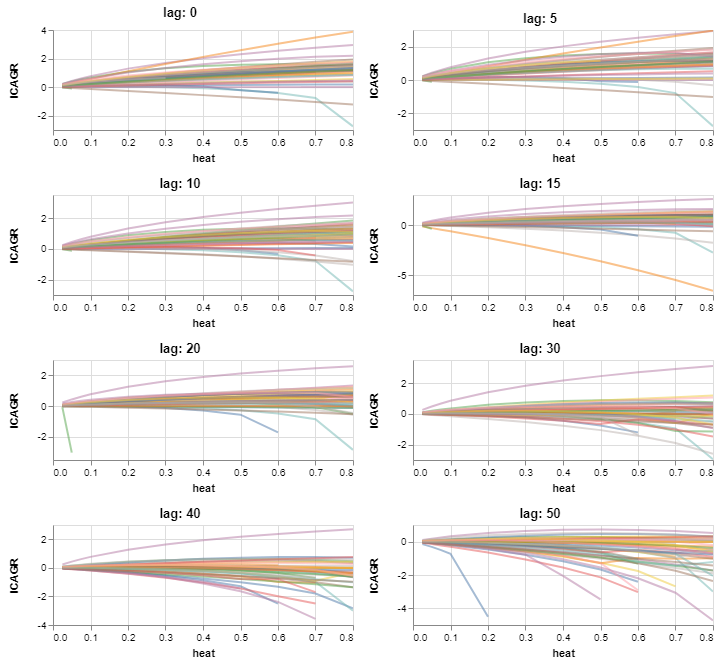

In [57]:
sd = 25
print('sd: ' + str(sd))
base = alt.Chart().mark_line(
    opacity=0.5,
    point=False,
).encode(
    x='heat',
    y='ICAGR',
    color=alt.Color('Ticker', legend=None),
    tooltip=['Ticker', 'sd', 'lag', 'ICAGR', 'Max_Drawdown', 'Bliss', 'heat', 'Lake_Ratio', 'Years'],
).properties(width=300, height=100).interactive()


chart = alt.vconcat(data=perf_df)
for i in range(len(lags) // 2):
    row = base.properties(title='lag: ' + str(lags[2 * i])).\
        transform_filter(datum.lag==lags[2 * i]).transform_filter(datum.sd==sd)
    row |= base.properties(title='lag: ' + str(lags[2 * i + 1])).\
        transform_filter(datum.lag==lags[2 * i + 1]).transform_filter(datum.sd==sd)
    chart &= row
chart

Ticker: BRKC1


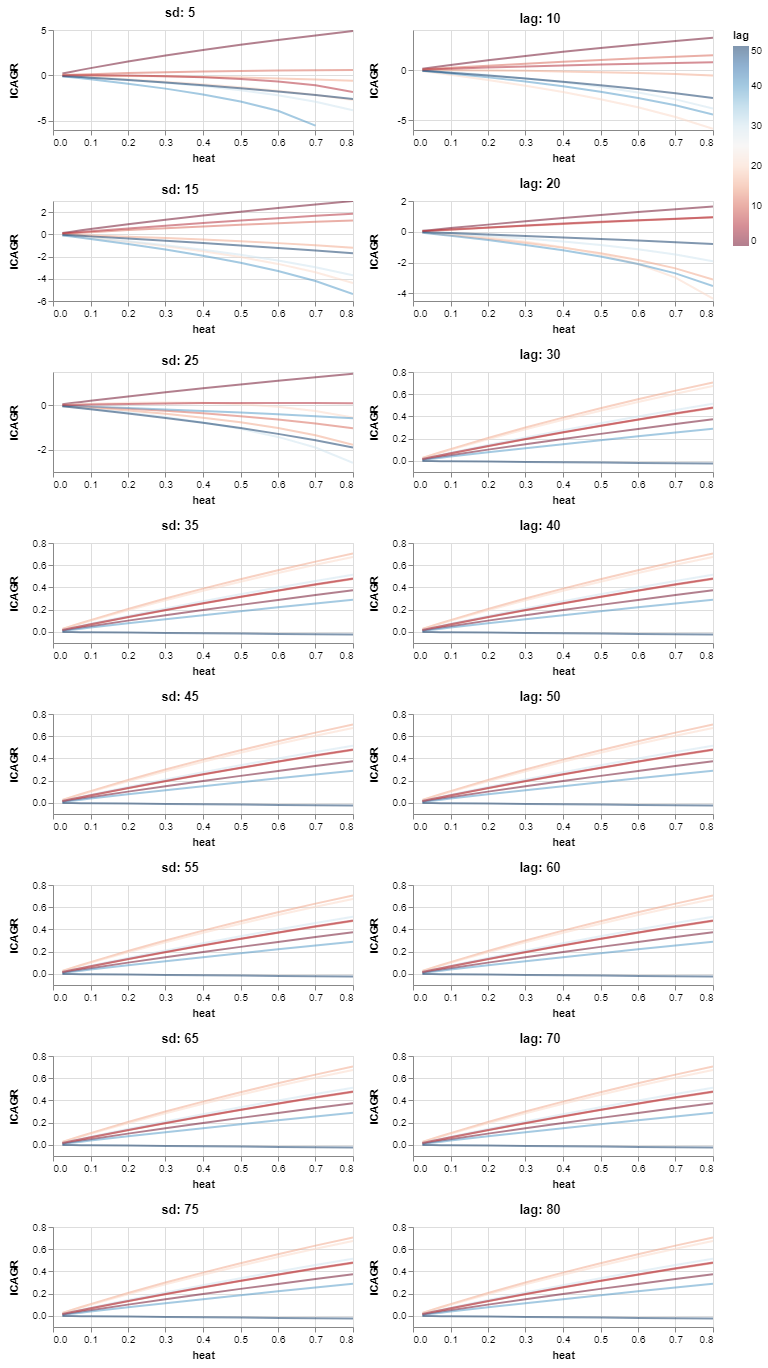

In [59]:
ticker = 'BRKC1'
print('Ticker:', ticker)
base = alt.Chart().mark_line(
    opacity=0.5,
    point=False
).encode(
    x='heat',
    y='ICAGR',
    color=alt.Color('lag', scale=alt.Scale(scheme='redblue')),
    tooltip=['heat', 'sd', 'lag', 'ICAGR', 'Bliss']
).properties(width=300, height=100).interactive()

chart = alt.vconcat(data=perf_df)
for i in range(len(sds) // 2):
    row = base.properties(title='sd: ' + str(sds[2 * i])).\
        transform_filter(datum.sd==sds[2 * i]).transform_filter(datum.Ticker==ticker)
    row |= base.properties(title='lag: ' + str(sds[2 * i + 1])).\
        transform_filter(datum.sd==sds[2 * i + 1]).transform_filter(datum.Ticker==ticker)
    chart &= row
chart

## Trades distribution

In [ ]:
n_tickers = 100
lag = 20

trades = []
grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
# grouped = prices.groupby('Ticker')
# grouped = prices.loc[list(set(trades_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    
    tr = find_trends(group.reset_index('Ticker'), 35)
    trend = tr.Trend.shift(lag).fillna(value=0)
    
    cheat_ts = Oracle_Trading_Strategy(
                   group.reset_index('Ticker'),
                   equity=1e6, name=name,
                   trend=tr.Trend.values,
                   max_dd=#tr.shift(lag).Max_Drawdown.fillna(method='ffill').fillna(method='bfill').values + \
                          tr.shift(lag).Max_Drawdown.fillna(method='ffill').fillna(method='bfill').values,
    )
    cheat_ts.excecute(warmup=1)
    try:
        trades.append(cheat_ts.get_trades_profit().assign(Ticker=name))
    except:
        pass

In [ ]:
def read_oracle_trades(f):
    ticker, sd, lag, heat = f.replace('.pickle', '').split('_')
    sd = float(sd)
    lag = int(lag)
    heat = float(heat)
    ch_ts = pickle.load(file=open(oracle_dir + f, 'rb'))
    
    return ch_ts.get_trades_profit().assign(Ticker=ticker, sd=sd, lag=lag, heat=heat)

oracle_dir = 'output/Oracles/'

res_trades = [read_oracle_trades(f) for f in os.listdir('output/Oracles/')]

In [ ]:
trades_df = pd.concat(trades, axis=0)
DataFrame(trades_df.PL_pct.agg(['min', 'max', 'mean', 'std',
                                'skew', 'kurtosis', 'count'])).transpose()

In [ ]:
trades_df.sort_values('PL_pct')

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

tit = "Trades' % P&L - " + str(int(10000 * (trades_df.PL > 0).mean())/100) + '% profitable, '
tit += str(int(10000 * (trades_df.Amount > 0).mean())/100) + '% Long.'
plt.subplot(211)
plt.title(tit)
trades_df.PL_pct.hist(cumulative=False, density=1, bins=1000, alpha=0.5)
plt.plot(np.arange(-10, 10, 0.05), stats.norm.pdf(np.arange(-10, 10, 0.05),
                                                  loc=trades_df.PL_pct.mean(),
                                                  scale=trades_df.PL_pct.std()))
plt.grid(c='grey', alpha=0.5)
plt.xlim((-5, 5))

plt.subplot(212)
trades_df.PL_pct.hist(cumulative=True, density=1, bins=1000, alpha=0.5)
plt.plot(np.arange(-10, 10, 0.05), stats.norm.cdf(np.arange(-10, 10, 0.05),
                                                  loc=trades_df.PL_pct.mean(),
                                                  scale=trades_df.PL_pct.std()))
plt.grid(c='grey', alpha=0.5)
plt.xlim((-5, 5))
plt.tight_layout()
plt.show()

# Data transforms for learning

In [ ]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

In [ ]:
df = price
tr = find_trends(df)
tr = tr[['Open', 'High', 'Low', 'Close', 'Volume', 'Set', 'Trend', 'Max_Drawdown', 'ATR', 'ICAGR']]
tr = tr.assign(Ch = tr.Close.pct_change().add(1).apply('log'))
tr = tr.assign(Ch2 = tr.Ch.pow(2), Ch3 = tr.Ch.pow(3), Ch4 = tr.Ch.pow(4))

In [ ]:
tr

In [ ]:
def transform_trends(df, sd=15):
    tr = find_trends(df, sd)
    tr = tr.loc

# TO DO:

1. Better estimation of stop_loss_pct.  Sometimes, the trend period's max_drawdown of the Close is too small.  Include High and Low in the calculation.  (c.f. ATR)
1. Determine the equivalence between SMA and lagged gaussian filter (which lag?).
1. Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
1. Exit by volume (~extreme reduction, bankrupt, ...).
1. Feature engineering.
  * c.f. fast.ai's `add_datepart` function.
